In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import pandas
from glob import glob
import keras
from tqdm import tqdm_notebook

In [3]:
files = np.array(glob('./lfw-deepfunneled/*/*'))

In [35]:
# It looks like all the images are the same size. That's great!
facebatch = np.zeros([10, 3, 250, 250])
for ix, file in enumerate(files[np.random.choice(files.shape[0], size=10)]):
    img = imread(file)
    facebatch[ix] = img.transpose([2, 0, 1])

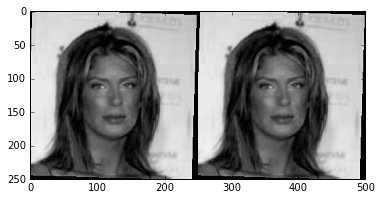

In [91]:
# Check we built the batch right
imshow(np.hstack([img[:, :, 2], facebatch[-1, 2]]), cmap='gray')

In [92]:
face_shape = [3, 250, 250]

In [104]:
# Let's build our network. It uses the Keras functional API

face_input = keras.layers.Input(shape=face_shape)
face_encoder = keras.layers.Convolution2D(64, 5, 5, border_mode='valid', activation='relu')(face_input)
face_encoder = keras.layers.MaxPooling2D([3, 3], border_mode='valid')(face_encoder)

face_encoder = keras.layers.Convolution2D(64, 5, 5, border_mode='valid', activation='relu')(face_encoder)
face_encoder = keras.layers.MaxPooling2D([3, 3], border_mode='valid')(face_encoder)

face_encoder = keras.layers.Convolution2D(64, 5, 5, border_mode='valid', activation='relu')(face_encoder)
face_encoder = keras.layers.MaxPooling2D([3, 3], border_mode='valid')(face_encoder)

face_encoder = keras.layers.Flatten()(face_encoder)
face_encoder = keras.layers.Dense(64, activation='relu')(face_encoder)

encoding_size = 32
face_encoder = keras.layers.Dense(encoding_size, activation='relu')(face_encoder)

In [86]:
face_mdl = keras.models.Model(face_input, face_encoder)

In [98]:
anchor_input = keras.layers.Input(shape=face_shape)
same_input = keras.layers.Input(shape=face_shape)
alt_input = keras.layers.Input(shape=face_shape)

anchor_encoded = face_mdl(anchor_input)
same_encoded = face_mdl(same_input)
alt_encoded = face_mdl(alt_input)

merged_outputs = keras.layers.merge([anchor_encoded, same_encoded, alt_encoded], mode='concat')

In [99]:
training_mdl = keras.models.Model([anchor_input, same_input, alt_input], merged_outputs)

In [101]:
training_mdl.predict([facebatch, facebatch, facebatch]).shape

(10, 96)

In [102]:
from keras import backend as K

In [105]:
def encoding_distance(vecs1, vecs2):
    return K.sqrt(K.sum(K.pow(vecs1 - vecs2, 2), 1))

alpha = 0.1
def triplet_loss(face_encoding, _):
    anchor = face_encoding[:, :encoding_size]
    same = face_encoding[:, encoding_size:2*encoding_size]
    alt = face_encoding[:, 2*encoding_size:]
    
    dist_same = encoding_distance(anchor, same)
    alt_dist = encoding_distance(anchor, alt)
    
    return dist_same - alt_dist + alpha

In [106]:
help(K.sum)

Help on function sum in module keras.backend.tensorflow_backend:

sum(x, axis=None, keepdims=False)
    Sum of the values in a tensor, alongside the specified axis.

